In this notebook, we will analyze, clean, and process the dataset of police stops to extract new insights, specifically:

*   Verifying the theory that the majority of violations are committed by young people at night due to speeding.
*   Analyzing the duration of police stops at different times of the day and the correlation between the outcomes of these stops and the time of day.
*   Identifying times when police are "less vigilant".
*   Extracting some intermediate information.


The dataset is sourced from https://www.kaggle.com/datasets/melihkanbay/police/data


Let's import all necessary libraries.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

path_to_df='/kaggle/input/police/police.csv'

# 1) Dataset Description

In [2]:
police_df = pd.read_csv(path_to_df)
display(police_df.info())
display(police_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91741 entries, 0 to 91740
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   stop_date           91741 non-null  object 
 1   stop_time           91741 non-null  object 
 2   county_name         0 non-null      float64
 3   driver_gender       86406 non-null  object 
 4   driver_age_raw      86414 non-null  float64
 5   driver_age          86120 non-null  float64
 6   driver_race         86408 non-null  object 
 7   violation_raw       86408 non-null  object 
 8   violation           86408 non-null  object 
 9   search_conducted    91741 non-null  bool   
 10  search_type         3196 non-null   object 
 11  stop_outcome        86408 non-null  object 
 12  is_arrested         86408 non-null  object 
 13  stop_duration       86408 non-null  object 
 14  drugs_related_stop  91741 non-null  bool   
dtypes: bool(2), float64(3), object(10)
memory usage: 9.3+

None

,stop_date,stop_time,county_name,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop
0,2005-01-02,01:55,NaN,M,1985.0,20.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
1,2005-01-18,08:15,NaN,M,1965.0,40.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
2,2005-01-23,23:15,NaN,M,1972.0,33.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
3,2005-02-20,17:15,NaN,M,1986.0,19.0,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False
4,2005-03-14,10:00,NaN,F,1984.0,21.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False


Since there is no full description available on Kaggle, based on internal considerations:

Columns:

*   `stop_date` - date of stop
*   `stop_time` - time of stop
*   `county_name` - name of the county
*   `driver_gender` - driver’s gender
*   `driver_age_raw` - driver’s year of birth
*   `driver_age` - driver’s age
*   `driver_race` - driver’s race
*   `violation_raw` - uncategorized violation
*   `violation` - categorized violation
*   `search_conducted` - whether a search was conducted
*   `search_type` - reason for the search
*   `stop_outcome` - outcome of the stop
*   `is_arrested` - whether anyone was arrested
*   `stop_duration` - duration of the stop
*   `drugs_related_stop` - whether the stop was drug-related/suspected*   drug-related


The original dataset contains 91,741 rows and 15 columns.

Based on the stop dates, the dataset covers the 2005-2015 years.

In [3]:
police_df.stop_date.agg(['min','max'])

min    2005-01-02
max    2015-12-31
Name: stop_date, dtype: object

# 2) Identification and correction of invalid data

## 2.1) Let's change the format of the columns where necessary.

Let's convert `stop_date` to a datetime type for more accurate code execution.

In [4]:
police_df['stop_date'] = pd.to_datetime(police_df['stop_date'])

We'll leave the other columns unchanged, as some are not needed and others still need to be cleaned.

## 2.2) Let's remove non-informative or empty columns and records.

The `county_name` column is empty. Let's check and remove it.

In [5]:
display(police_df['county_name'].value_counts(dropna=False))
police_df.drop(columns=['county_name'], inplace=True)

county_name
NaN    91741
Name: count, dtype: int64

The `driver_age` and `driver_age_raw` columns provide the same information. `driver_age_raw` is the year of birth, while `driver_age` is the driver’s age. Let's remove the year of birth column as it is unnecessary.

In [6]:
display(police_df[['driver_age_raw','driver_age']].head())
police_df.drop(columns=['driver_age_raw'], inplace=True)

,driver_age_raw,driver_age
0,1985.0,20.0
1,1965.0,40.0
2,1972.0,33.0
3,1986.0,19.0
4,1984.0,21.0


The `search_conducted` column contains information that is not needed and may also be inaccurate. We will verify this by comparing it with the `drugs_related_stop` column, where a True value should indicate that the search constitutes a large portion of cases. Let's remove the `search_conducted` column.

In [7]:
display(police_df.groupby(['search_conducted','drugs_related_stop']).agg({'drugs_related_stop':'count'}))
police_df.drop(columns=['search_conducted'], inplace=True)

drugs_related_stop
search_conducted drugs_related_stop                    
False            False                            88545
True             False                             2381
                 True                               815

The `is_arrested` column is also non-informative, as its information is represented in the `stop_outcome` column as "Arrest Driver" or "Arrest Passenger." We will verify this and then remove the `is_arrested` column.

In [8]:
print('---All possible outcomes of stops when is_arrested == True and their counts:---')
display(police_df.loc[(police_df['is_arrested']==True),'stop_outcome'].value_counts())
police_df.drop(columns=['is_arrested'], inplace=True)

---All possible outcomes of stops when is_arrested == True and their counts:---


stop_outcome
Arrest Driver       2571
Arrest Passenger     358
Name: count, dtype: int64

The `violation_raw` column provides more detailed information about the type of violation, while the violation column categorizes it into 6 groups:

*   Speeding - violation of speed limits
*   Moving violation - violation of traffic rules
*   Equipment - issues with vehicle equipment or condition (e.g., *   non-functioning lights, missing first aid kit, etc.)
*   Other - other reasons
*   Registration/plates - issues with registration or license plates
*   Seat belt - seat belt not fastened

The original `violation_raw` column is unnecessary for us, as the only information it provides is for 'Other' types of violations.


In [9]:
print('The distribution of all violation categories with the types of violations and their counts:\n')
display(police_df.groupby(['violation','violation_raw']).agg({'violation_raw':'count'}))
police_df.drop(columns=['violation_raw'], inplace=True)

The distribution of all violation categories with the types of violations and their counts:



violation_raw
violation           violation_raw                                  
Equipment           Equipment/Inspection Violation            11020
Moving violation    Other Traffic Violation                   16224
Other               APB                                          79
                    Call for Service                           1298
                    Motorist Assist/Courtesy                    203
                    Special Detail/Directed Patrol             2455
                    Suspicious Person                            56
                    Violation of City/Town Ordinance            211
                    Warrant                                      15
Registration/plates Registration Violation                     3432
Seat belt           Seatbelt Violation                         2952
Speeding            Speeding                                  48463

The `search_type` column stores information about the primary reason for the search. However, since a search was not conducted in every stop, this column is mostly empty and not very informative. Let's remove it.

In [10]:
print('All primary reasons for searches and their counts:\n')
display(police_df['search_type'].value_counts(dropna=False))
police_df.drop(columns=['search_type'], inplace=True)

All primary reasons for searches and their counts:



search_type
NaN                                                         88545
Incident to Arrest                                           1219
Probable Cause                                                891
Inventory                                                     220
Reasonable Suspicion                                          197
Protective Frisk                                              161
Incident to Arrest,Inventory                                  129
Incident to Arrest,Probable Cause                             106
Probable Cause,Reasonable Suspicion                            75
Incident to Arrest,Inventory,Probable Cause                    34
Probable Cause,Protective Frisk                                33
Incident to Arrest,Protective Frisk                            33
Inventory,Probable Cause                                       22
Incident to Arrest,Reasonable Suspicion                        13
Incident to Arrest,Inventory,Protective Frisk                  1

Let's correct records with missing values. First, we'll remove records that are completely empty.

We'll find the column where NaN indicates empty rows in all other columns.

In [11]:
police_df.groupby(police_df["driver_age"].isna())[['driver_race','stop_duration','driver_gender']].value_counts(dropna=False).unstack()

driver_gender                               F        M     NaN
driver_age driver_race stop_duration                          
False      Asian       0-15 Min         440.0   1457.0     NaN
                       16-30 Min         64.0    224.0     NaN
                       30+ Min            7.0     61.0     NaN
           Black       0-15 Min        2107.0   7362.0     NaN
                       16-30 Min        394.0   1693.0     NaN
                       2                  NaN      1.0     NaN
                       30+ Min           76.0    564.0     NaN
           Hispanic    0-15 Min        1558.0   5869.0     NaN
                       16-30 Min        260.0   1294.0     NaN
                       30+ Min           49.0    447.0     NaN
           Other       0-15 Min          23.0    178.0     NaN
                       16-30 Min          3.0     30.0     NaN
                       30+ Min            NaN      5.0     NaN
           White       0-15 Min       15556.0  34784.0     2.0
                       1                  1.0      NaN     NaN
                       16-30 Min       2662.0   6934.0     NaN
                       30+ Min          264.0   1746.0     NaN
           NaN         NaN                NaN      NaN     5.0
True       Asian       0-15 Min           1.0      1.0     NaN
                       16-30 Min          1.0      2.0     NaN
                       30+ Min            NaN      1.0     NaN
           Black       0-15 Min           2.0     29.0     NaN
                       16-30 Min          1.0     14.0     NaN
                       30+ Min            NaN      1.0     NaN
           Hispanic    0-15 Min           2.0     12.0     NaN
                       16-30 Min          2.0     13.0     NaN
                       30+ Min            NaN      1.0     NaN
           Other       16-30 Min          NaN      1.0     NaN
           White       0-15 Min          35.0    125.0     NaN
                       16-30 Min          3.0     40.0     NaN
                       30+ Min            NaN      6.0     NaN
           NaN         NaN                NaN      NaN  5328.0

As we can see, if we choose the `driver_age` column, we will remove the largest number of NaNs from the dataset, but we will also lose a significant number of records. If we choose the `driver_race` column, the loss will be smaller.

In [12]:
police_df.groupby(police_df["driver_race"].isna())[['driver_age','stop_duration','driver_gender']].value_counts(dropna=False).unstack()

driver_gender                           F     M     NaN
driver_race driver_age stop_duration                   
False       15.0       0-15 Min       1.0   1.0     NaN
                       16-30 Min      1.0   NaN     NaN
                       30+ Min        NaN   2.0     NaN
            16.0       0-15 Min       8.0  23.0     NaN
                       16-30 Min      3.0   5.0     NaN
...                                   ...   ...     ...
True        21.0       NaN            NaN   NaN     1.0
            28.0       NaN            NaN   NaN     1.0
            37.0       NaN            NaN   NaN     1.0
            38.0       NaN            NaN   NaN     1.0
            NaN        NaN            NaN   NaN  5328.0

[229 rows x 3 columns]

Let's remove the empty records and then check the number of records with missing values.

In [13]:
police_df = police_df[~police_df['driver_race'].isin([np.nan])]

driver_age_nan_len = len(police_df[police_df['driver_age'].isna()])
print(f'Total number of records with empty fields driver_age = {driver_age_nan_len}')

driver_gender_nan_len = len(police_df[police_df['driver_gender'].isna()])
print(f'Total number of records with empty fields driver_gender = {driver_gender_nan_len}')

stop_duration_nan_len = len(police_df[police_df['stop_duration'].isna()])
print(f'Total number of records with empty fields stop_duration = {stop_duration_nan_len}')

Total number of records with empty fields driver_age = 293
Total number of records with empty fields driver_gender = 2
Total number of records with empty fields stop_duration = 0


## 2.3) Let's fill in the missing values with data.



We still have some missing values that can be filled.

For `driver_gender`, we can fill the missing values with 'M' and 'W' respectively, as 2 records will not significantly impact the dataset.

In [14]:
def driver_gender_nan_replace(value):
    if pd.isna(value):
        return np.random.choice(['M', 'F'])
    return value

police_df['driver_gender'] = police_df['driver_gender'].apply(driver_gender_nan_replace)
driver_gender_nan_len = len(police_df[police_df['driver_gender'].isna()])
print(f'Total number of records with empty fields driver_gender = {driver_gender_nan_len}')

Total number of records with empty fields driver_gender = 0


Filling in `driver_age` will be a bit more complex. Let's find the average age range of all offenders and distribute the missing values within this range. With 86,408 records, we can distribute the 293 missing values within the range between the 1st and 3rd quartiles without significant issues.

In [15]:
police_df.groupby('driver_gender')['driver_age'].describe()

,count,mean,std,min,25%,50%,75%,max
driver_gender,,,,,,,,
F,23465.0,32.607074,12.156016,15.0,23.0,29.0,41.0,99.0
M,62650.0,34.537733,12.911028,15.0,24.0,31.0,43.0,94.0


As we can see, for women, the age range can be considered from 23 to 41, and for men, from 24 to 43 years. Let's randomly distribute the missing values within these ranges.

In [16]:
def driver_age_nan_replace(value, gender):
    if pd.isna(value):
        if gender == "F":
            return np.random.randint(23, 41)
        else:
            return np.random.randint(24, 43)
    return value

police_df['driver_age'] = police_df.apply(lambda row: driver_age_nan_replace(row['driver_age'], row['driver_gender']), axis=1)

driver_age_nan_len = len(police_df[police_df['driver_age'].isna()])
print(f'Total number of records with empty fields driver_age = {driver_age_nan_len}')

Total number of records with empty fields driver_age = 0


## 2.4) Let's correct errors in the data.

After filling in the missing values in `driver_age`, we can change its data type to integer.

In [17]:
police_df['driver_age'] = police_df['driver_age'].astype(int)

There were 2 errors in the `stop_duration` column.

In [18]:
police_df['stop_duration'].value_counts()

stop_duration
0-15 Min     69543
16-30 Min    13635
30+ Min       3228
2                1
1                1
Name: count, dtype: int64

Let's replace the exceptions with the most common stop duration.

In [19]:
police_df['stop_duration'].replace(to_replace=['1','2'], value=['0-15 Min','0-15 Min'], inplace=True)

## 2.5) Let's remove duplicates.

Let's check for duplicates and remove them.

In [20]:
num_duplicates = police_df.duplicated().sum()
print(f'Number of duplicates: {num_duplicates}')

police_df= police_df.drop_duplicates()

Number of duplicates: 273


### After completing all transformations, we have the dataset in the following format:


Number of records: 86,135, Number of columns: 9.

Empty and non-informative columns have been removed. Data types have been corrected. Missing and incorrect values in records have been replaced.

In [21]:
police_df.info()
display(police_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 86135 entries, 0 to 91740
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   stop_date           86135 non-null  datetime64[ns]
 1   stop_time           86135 non-null  object        
 2   driver_gender       86135 non-null  object        
 3   driver_age          86135 non-null  int64         
 4   driver_race         86135 non-null  object        
 5   violation           86135 non-null  object        
 6   stop_outcome        86135 non-null  object        
 7   stop_duration       86135 non-null  object        
 8   drugs_related_stop  86135 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(1), object(6)
memory usage: 6.0+ MB


,stop_date,stop_time,driver_gender,driver_age,driver_race,violation,stop_outcome,stop_duration,drugs_related_stop
0,2005-01-02,01:55,M,20,White,Speeding,Citation,0-15 Min,False
1,2005-01-18,08:15,M,40,White,Speeding,Citation,0-15 Min,False
2,2005-01-23,23:15,M,33,White,Speeding,Citation,0-15 Min,False
3,2005-02-20,17:15,M,19,White,Other,Arrest Driver,16-30 Min,False
4,2005-03-14,10:00,F,21,White,Speeding,Citation,0-15 Min,False


# 3) Identification of patterns and extraction of new insights

## 3.1) Testing the theory that the majority of violations occur:

1.   Due to speeding
1.   By young people
1.   At night

And formulating theories on what this might be related to.


### 3.1.1) Due to speeding

Looking at the overall statistics on the number of violations, there is no doubt that speeding is the most common type of violation.

In [22]:
display(police_df['violation'].value_counts())

violation
Speeding               48320
Moving violation       16170
Equipment              10990
Other                   4297
Registration/plates     3412
Seat belt               2946
Name: count, dtype: int64

The number of speeding violations significantly exceeds the others. However, we currently have no basis to assume that this type of violation occurs more frequently in the evening. We will later compare the number of violations over different time periods.

### 3.1.2) By Young People
Let's add a new column `age_range`, categorizing driver ages into ranges for statistical analysis.

In [23]:
police_df['age_range']=pd.cut(police_df['driver_age'], bins=np.arange(10.0,90.0,10), right=False)

Let's display the statistics in a diagram to visually represent the number of speeding violators across different age groups.

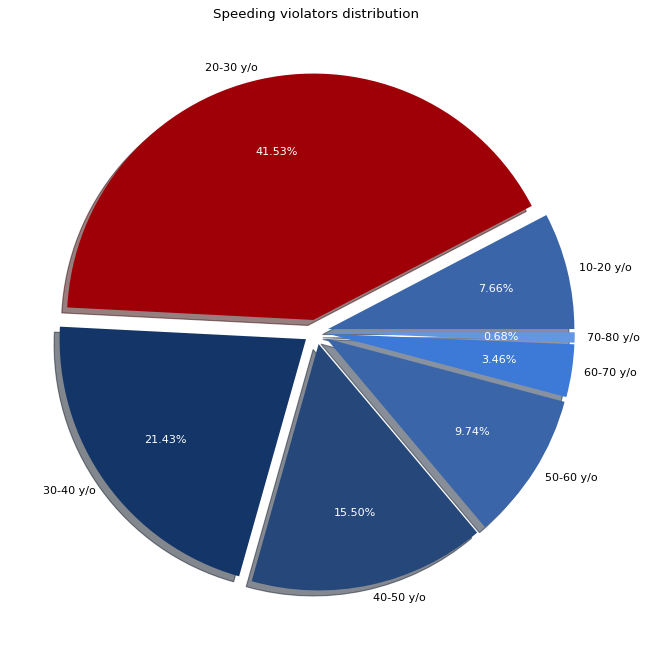

age_range
[10.0, 20.0)     3696
[20.0, 30.0)    20048
[30.0, 40.0)    10346
[40.0, 50.0)     7483
[50.0, 60.0)     4703
[60.0, 70.0)     1668
[70.0, 80.0)      326
Name: violation, dtype: int64

In [24]:
speeding_counts = police_df[police_df['violation'] == 'Speeding'].groupby('age_range')['violation'].count()
plt.figure(figsize=(10, 10), dpi=80)
explode=[0.05, 0.05, 0.05, 0.05,0.05,0.05,0.05]
_, _, autotexts = plt.pie(
    speeding_counts,
    colors=[ "#3a66a9", "#9f0008", "#143568", "#254779","#3a66a9","#3d7ad7","#6596e1",],
    labels=["10-20 y/o", "20-30 y/o", "30-40 y/o", "40-50 y/o","50-60 y/o","60-70 y/o","70-80 y/o"],
    shadow=True,
    explode=explode,
    autopct="%.2f%%",
    pctdistance=0.70,
    labeldistance=1.05,
)
for autotext in autotexts:
    autotext.set_color('white')

plt.title('Speeding violators distribution')
plt.show()
display(speeding_counts)

As we can see, the largest number of speeding violators belongs to the age group of 20 to 30 years.

### 3.1.3) At night

Let's first add a new column `time_range`, where we will categorize the time of stops into time ranges. We will use only the end time of each range for simplicity. For example, for a range from "2:00 to 3:00," we will use only "3:00" in the column for easier visualization. Thus, a record of "5:00" will represent the time range from 4:00 to 5:00 in the morning.

In [25]:
police_df['stop_time']= pd.to_datetime(police_df['stop_time'])
bins2= pd.date_range(start='00:00:00', end='23:00:00', freq='1H')
bins2_str = bins2.strftime('%H:%M:%S').tolist()
bins2_str.append('23:59:59')
bins2 = pd.to_datetime(bins2_str)
labels2 = [f'{bins2[i+1].strftime("%H:%M")}' for i in range(len(bins2)-1)]
police_df['time_range'] = pd.cut(police_df['stop_time'], bins=bins2, labels=labels2, right=False)

/tmp/ipykernel_17/1609637713.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  police_df['stop_time']= pd.to_datetime(police_df['stop_time'])
/tmp/ipykernel_17/1609637713.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bins2 = pd.to_datetime(bins2_str)


Now we can break down the statistics obtained in section 3.1.2 by time intervals and display this information in a graph for better visualization.

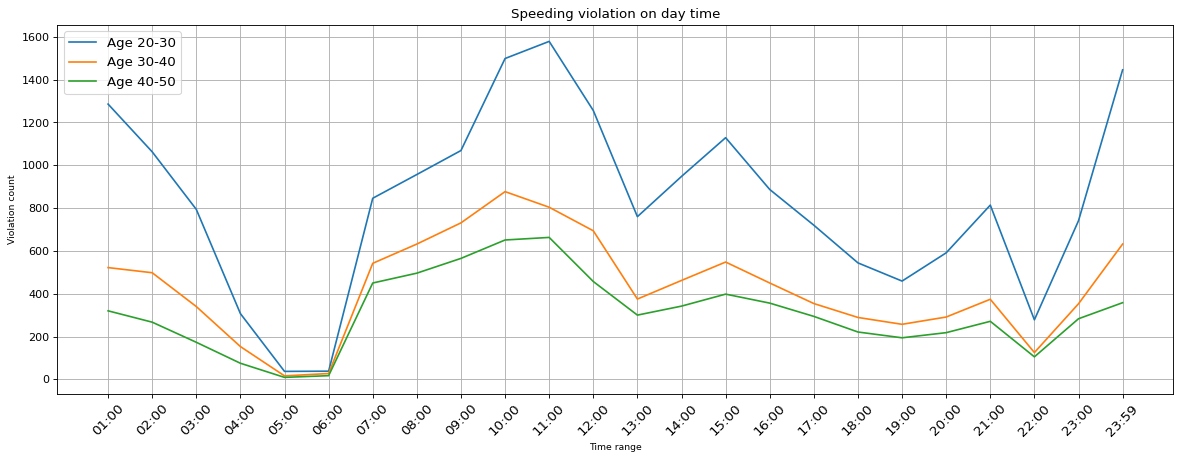

In [26]:
plt.figure(figsize=(18, 6), dpi=80)
police_df['age_range']=police_df['age_range'].astype(str)
filtered_speed_df = police_df[police_df['violation'] == 'Speeding'].copy(deep=True)
interval20_30=filtered_speed_df[filtered_speed_df['age_range']=='[20.0, 30.0)'].groupby('time_range')['violation'].count()
plt.plot(
    interval20_30,
    label="Age 20-30")
interval30_40=filtered_speed_df[filtered_speed_df['age_range']=='[30.0, 40.0)'].groupby('time_range')['violation'].count()
plt.plot(
    interval30_40,
    label="Age 30-40")
interval40_50=filtered_speed_df[filtered_speed_df['age_range']=='[40.0, 50.0)'].groupby('time_range')['violation'].count()
plt.plot(
    interval40_50,
    label='Age 40-50')
plt.ylabel('Violation count', fontsize='small')
plt.xlabel('Time range', fontsize='small')
plt.title('Speeding violation on day time')
plt.xticks(fontsize=12, rotation=45)
plt.legend(fontsize=12,)
plt.grid()
plt.show()

As we can see, the highest number of violations occurs during the day (from 10:00 to 11:00) and at night (from 00:00 to 01:00). However, the overall statistics might look different. Let's calculate the percentage of speeding violations for different age groups relative to all speeding violations within the time intervals and to all violations in general.

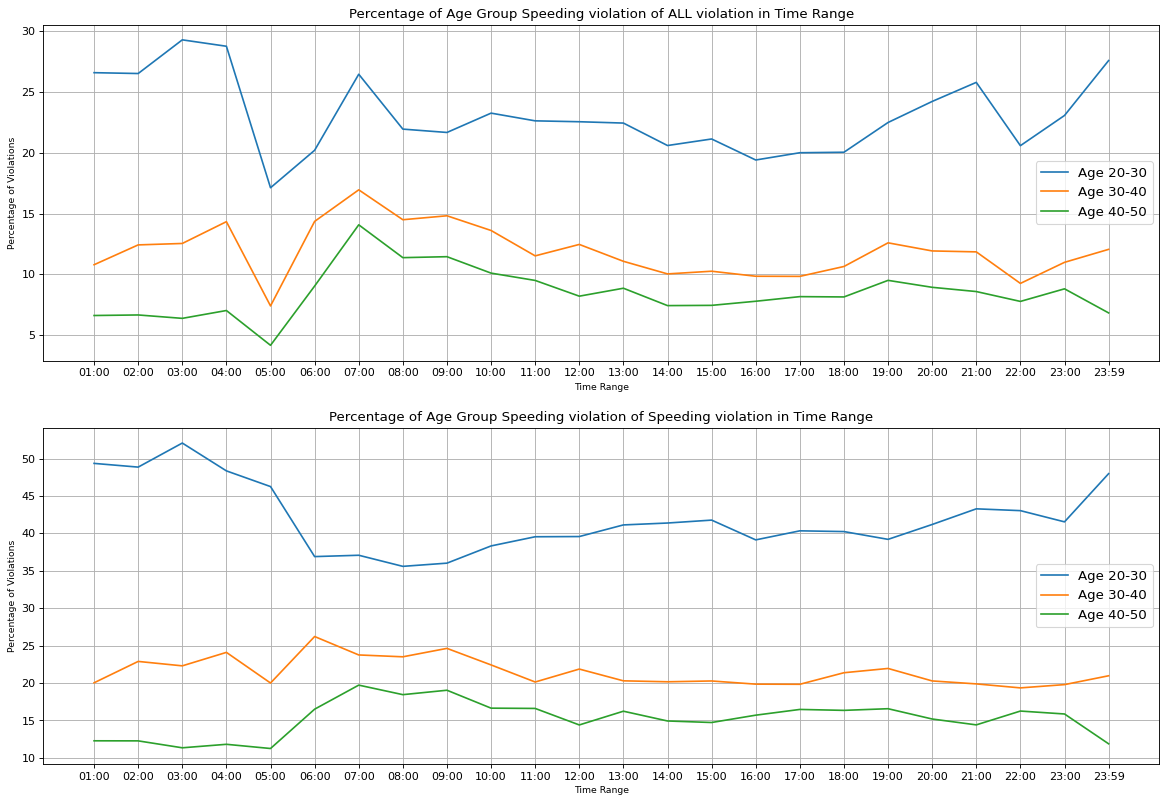

In [27]:
fig, axs = plt.subplots(2,1, figsize=(18, 12), dpi=80)

interval20_30 = filtered_speed_df[filtered_speed_df['age_range'] == '[20.0, 30.0)'].groupby('time_range')['violation'].count()
interval30_40 = filtered_speed_df[filtered_speed_df['age_range'] == '[30.0, 40.0)'].groupby('time_range')['violation'].count()
interval40_50 = filtered_speed_df[filtered_speed_df['age_range'] == '[40.0, 50.0)'].groupby('time_range')['violation'].count()
# Total number of violations for each time interval
total_violation_sp = filtered_speed_df.groupby('time_range')['violation'].count()
total_violations = police_df.groupby('time_range')['violation'].count()

# Percentage calculation 1
percentage20_30 = (interval20_30 / total_violations) * 100
percentage30_40 = (interval30_40 / total_violations) * 100
percentage40_50 = (interval40_50 / total_violations) * 100

# Percentage calculation 2
percentage20_30_sp = (interval20_30 / total_violation_sp) * 100
percentage30_40_sp = (interval30_40 / total_violation_sp) * 100
percentage40_50_sp = (interval40_50 / total_violation_sp) * 100

# Graph plotting 1
axs[0].plot(percentage20_30, label="Age 20-30")
axs[0].plot(percentage30_40, label="Age 30-40")
axs[0].plot(percentage40_50, label="Age 40-50")
# Graph plotting 2
axs[1].plot(percentage20_30_sp, label="Age 20-30")
axs[1].plot(percentage30_40_sp, label="Age 30-40")
axs[1].plot(percentage40_50_sp, label="Age 40-50")


# Graph settings
axs[0].set_xlabel("Time Range", fontsize='small')
axs[0].set_ylabel("Percentage of Violations", fontsize='small')
axs[0].set_title("Percentage of Age Group Speeding violation of ALL violation in Time Range")

axs[1].set_xlabel("Time Range", fontsize='small')
axs[1].set_ylabel("Percentage of Violations", fontsize='small')
axs[1].set_title("Percentage of Age Group Speeding violation of Speeding violation in Time Range")

axs[0].legend(fontsize=12)
axs[1].legend(fontsize=12)
axs[0].grid()
axs[1].grid()
plt.show()

As we can see, there are several percentage peaks of violations committed throughout the day when comparing the number of speeding violations to the total number of violations. However, if we look at the ratio of age groups to all speeding violations, we notice a significant predominance of violations committed by young people aged 20-30, especially at night.

Returning to section 3.1.1, let's confirm the statement that speeding is the most common violation at night by comparing it with other types of violations. To do this, we will display the proportion of all types of violations within the time intervals.

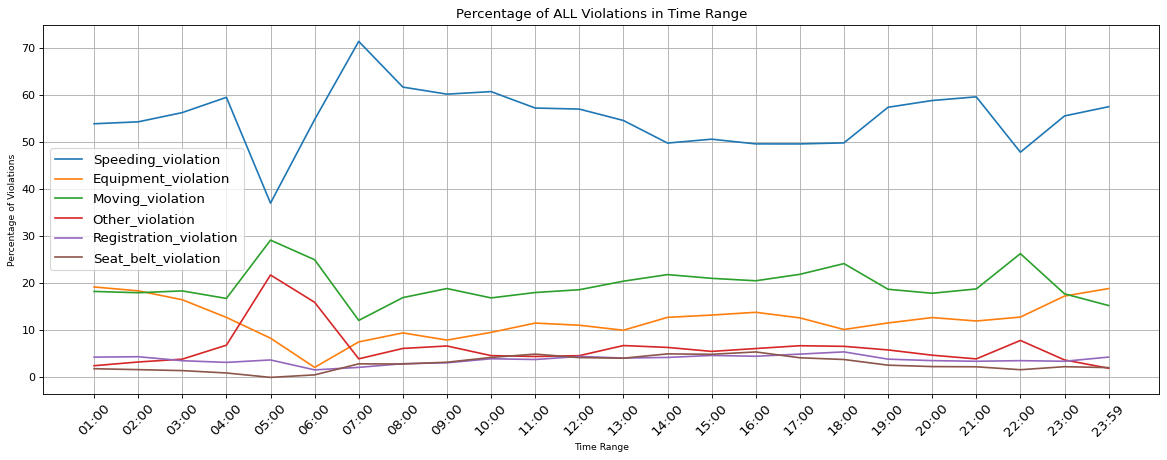

In [28]:
plt.figure(figsize=(18, 6), dpi=80)

Speeding_violation = police_df[police_df['violation'] == 'Speeding'].groupby('time_range')['violation'].count()
Equipment_violation = police_df[police_df['violation'] == 'Equipment'].groupby('time_range')['violation'].count()
Moving_violation = police_df[police_df['violation'] == 'Moving violation'].groupby('time_range')['violation'].count()
Other_violation = police_df[police_df['violation'] == 'Other'].groupby('time_range')['violation'].count()
Registration_violation = police_df[police_df['violation'] == 'Registration/plates'].groupby('time_range')['violation'].count()
Seat_belt_violation = police_df[police_df['violation'] == 'Seat belt'].groupby('time_range')['violation'].count()

# Total number of violations for each time interval
total_violations = police_df.groupby('time_range')['violation'].count()

# Percentage calculation
percentage_Speeding = (Speeding_violation / total_violations) * 100
percentage_Equipment = (Equipment_violation / total_violations) * 100
percentage_Moving = (Moving_violation / total_violations) * 100
percentage_Other = (Other_violation / total_violations) * 100
percentage_Registration = (Registration_violation / total_violations) * 100
percentage_Seat_belt = (Seat_belt_violation / total_violations) * 100

# Graph plotting
plt.plot(percentage_Speeding, label="Speeding_violation")
plt.plot(percentage_Equipment, label="Equipment_violation")
plt.plot(percentage_Moving, label="Moving_violation")
plt.plot(percentage_Other, label="Other_violation")
plt.plot(percentage_Registration, label="Registration_violation")
plt.plot(percentage_Seat_belt, label="Seat_belt_violation")

# Graph settings
plt.xlabel("Time Range", fontsize='small')
plt.ylabel("Percentage of Violations", fontsize='small')
plt.title("Percentage of ALL Violations in Time Range")
plt.xticks(fontsize=12, rotation=45)
plt.legend(fontsize=12,)
plt.grid()
plt.show()

As we can see, between 06:00 and 07:00, there is the peak number of speeding violations, accounting for about 72% of all violations. Considering that 34% of these violations are committed by people aged 20 to 30, it can be assumed that these are likely individuals rushing to work in cities that have not yet filled with traffic jams.

## 3.2) Duration of police stops at different times of the day
...and their outcomes

Imagine the following scenario: You are running late for the most important meeting of your life, so you decide to break the law. However, the police are vigilant, maintaining order on the roads, and stop you for your violation. How long will the stop take, and what will be the outcome?

Based on the graph in section 3.1.3, we can confidently say that in the morning, stops for any type of violation are less frequent. However, if you are stopped, during which time interval is a stop for speeding likely to be the shortest?

The `stop_duration` column is categorized into only a few time intervals for the stop duration.


*   0-15 Min
*   16-30 Min
*   30+ Min






### 3.2.1) Let's check if the duration of the stop depends on the type of violation:

First, let's determine the duration of various types of violations and display the percentage distribution:

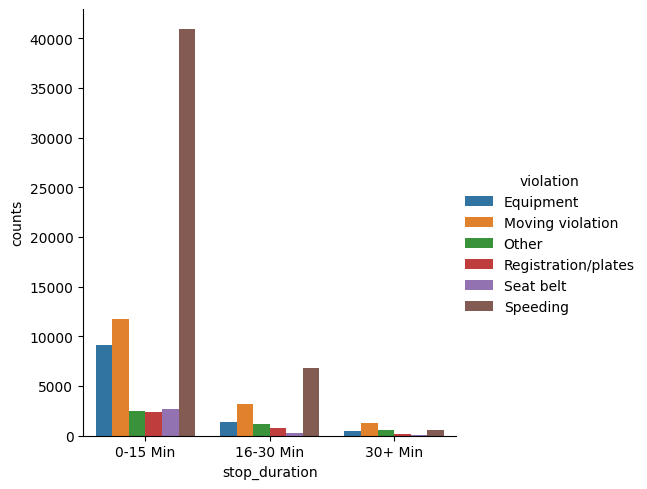

In [29]:
stop_and_violation = police_df.groupby(['violation', 'stop_duration']).size().reset_index(name='counts')
sns.catplot(x="stop_duration", y="counts", hue="violation", kind="bar", data=stop_and_violation)
plt.show()

All stops for different types of violations show a similar trend of decreasing frequency as the stop duration increases.

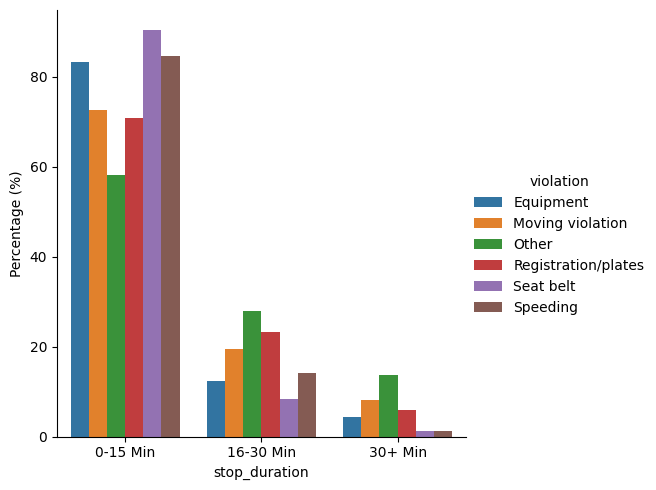

In [30]:
# Group the data and count the number of unique stop_duration values for each violation.
stop_and_violation = police_df.groupby(['violation', 'stop_duration']).size().reset_index(name='counts')

# Calculate the total number of cases for each violation.
total_counts = stop_and_violation.groupby('violation')['counts'].transform('sum')

# Calculate the percentages
stop_and_violation['percent'] = (stop_and_violation['counts'] / total_counts) * 100

# Plot a graph with the percentages
sns.catplot(x="stop_duration", y="percent", hue="violation", kind="bar", data=stop_and_violation)
plt.ylabel('Percentage (%)')
plt.show()

This graph indicates that almost all stops for not wearing a seat belt lasted less than 15 minutes, more so than for other types of violations.

### 3.2.2) Let's determine how long a stop for speeding takes during different times of the day.

To achieve this, let's output the minimum, maximum and mean stop duration values. We will add a new column, `min_max_stop_time`, where we will record all these values.



In [31]:
def stoptime_min_max(value):
    if value == '0-15 Min':
        return [0.5, 15.9, 7.5]
    elif value == '16-30 Min':
        return [16.0, 29.9, 23.5]
    else:
        return [30.0, 60.0, 45.0]
police_df['min_max_stop_time'] = police_df['stop_duration'].apply(stoptime_min_max)

The graph shows the maximum, minimum, and most likely average durations of stops at different times of the day.

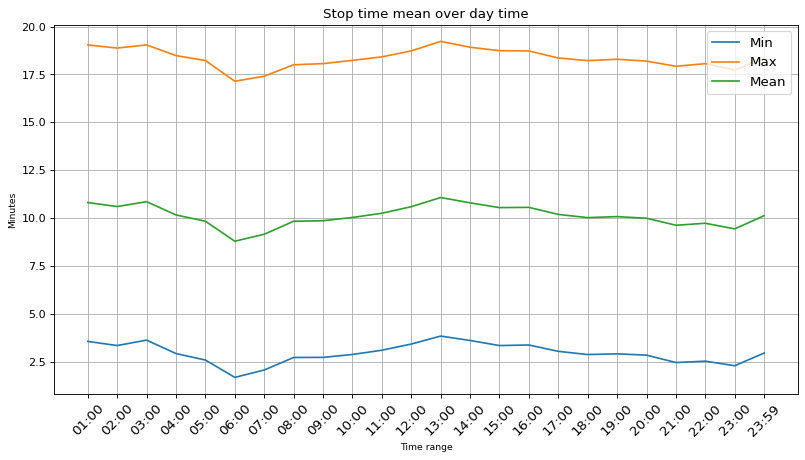

In [32]:
plt.figure(figsize=(12, 6), dpi=80)
filtered_speed_df['min_stop_time'] = police_df['min_max_stop_time'].apply(lambda x: x[0])
stop_time_min_mean=filtered_speed_df.groupby('time_range')['min_stop_time'].mean()
plt.plot(
    stop_time_min_mean,
    label="Min")

filtered_speed_df['max_stop_time'] = police_df['min_max_stop_time'].apply(lambda x: x[1])
stop_time_max_mean=filtered_speed_df.groupby('time_range')['max_stop_time'].mean()
plt.plot(
    stop_time_max_mean,
    label="Max")

filtered_speed_df['mean_stop_time'] = police_df['min_max_stop_time'].apply(lambda x: x[2])
stop_time_mean_mean=filtered_speed_df.groupby('time_range')['mean_stop_time'].mean()
plt.plot(
    stop_time_mean_mean,
    label="Mean")

plt.ylabel('Minutes', fontsize='small')
plt.xlabel('Time range', fontsize='small')
plt.title('Stop time mean over day time')
plt.xticks(fontsize=12, rotation=45)
plt.legend(fontsize=12,)
plt.grid()
plt.show()

Thus, we can see that the shortest stop duration occurs between 05:00 and 06:00, while the longest average stop durations are between 02:00 and 03:00, and 12:00 and 13:00. The mean value reflects the most realistic average duration of stops.

### 3.2.3) Now that we know how long stops last during different times of the day, can a stop extend for an EXTREMELY long time?

Let's make a small correction to our statistics. Not all stops end with the driver being allowed to continue. Some violators were arrested, and there are also cases where passengers were arrested.

/tmp/ipykernel_17/2216072769.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filter_stop_arest=filtered_speed_df[(police_df['stop_outcome'] == 'Arrest Driver')|(police_df['stop_outcome'] == 'Arrest Passenger')].copy(deep=True)


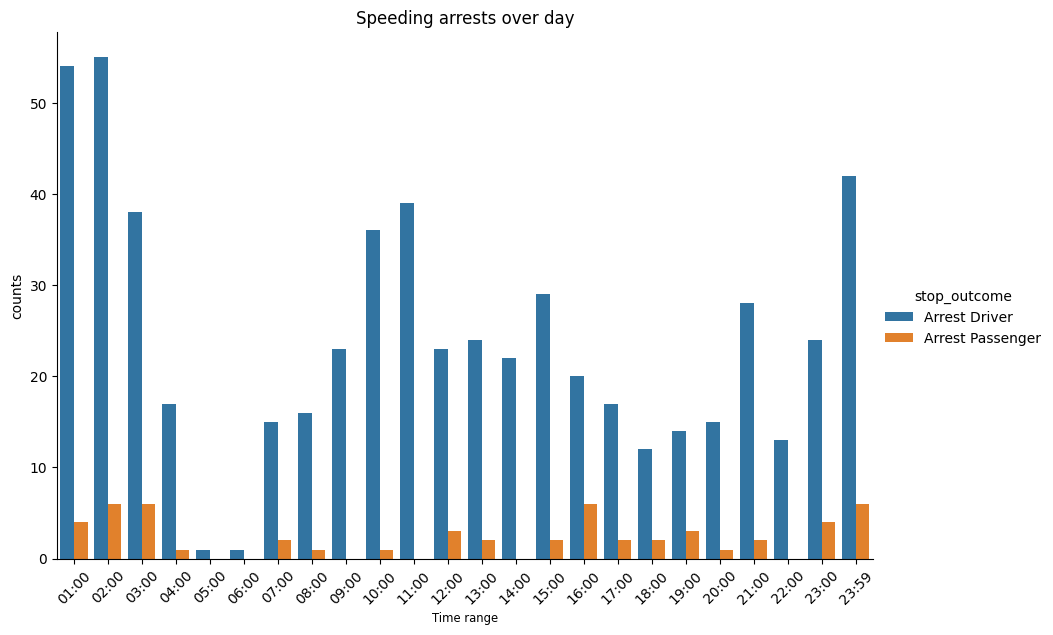

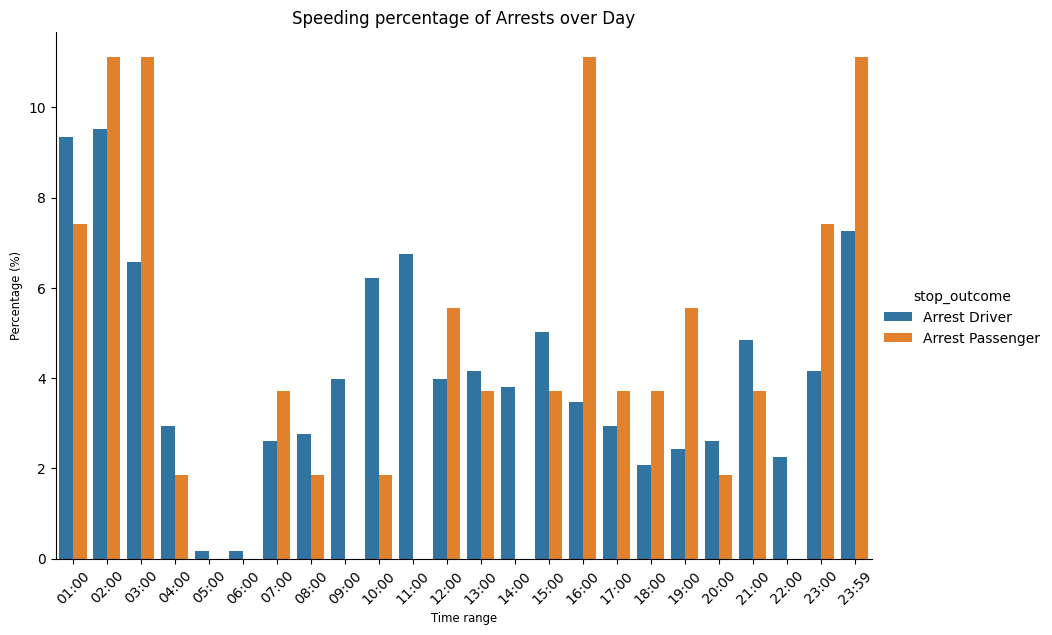

In [33]:
filter_stop_arest=filtered_speed_df[(police_df['stop_outcome'] == 'Arrest Driver')|(police_df['stop_outcome'] == 'Arrest Passenger')].copy(deep=True)

is_arested_in_day = filter_stop_arest.groupby(['stop_outcome', 'time_range']).size().reset_index(name='counts')

total_arrests_per_outcome = is_arested_in_day.groupby('stop_outcome')['counts'].transform('sum')

is_arested_in_day['percentage'] = (is_arested_in_day['counts'] / total_arrests_per_outcome) * 100

sns.catplot(x="time_range", y="counts", hue="stop_outcome", kind="bar", data=is_arested_in_day, height=6, aspect=1.5)
plt.xticks( rotation=45)
plt.xlabel('Time range', fontsize='small')
plt.title('Speeding arrests over day')

sns.catplot(x="time_range", y="percentage", hue="stop_outcome", kind="bar", data=is_arested_in_day, height=6, aspect=1.5)
plt.xticks(rotation=45)
plt.xlabel('Time range', fontsize='small')
plt.ylabel('Percentage (%)', fontsize='small')
plt.title('Speeding percentage of Arrests over Day')
plt.show()

As we can see, drivers are most frequently arrested, especially at night. Passengers are arrested less often, but over 45% of these arrests also occur at night. An interesting observation is the ~11% peak in arrests between 15:00 and 16:00.

Arrests are least frequent in the early morning hours, from 03:00 to 09:00.

### 3.2.4) Is it possible to get away with just a warning?

Of course, fines are the most common outcome.

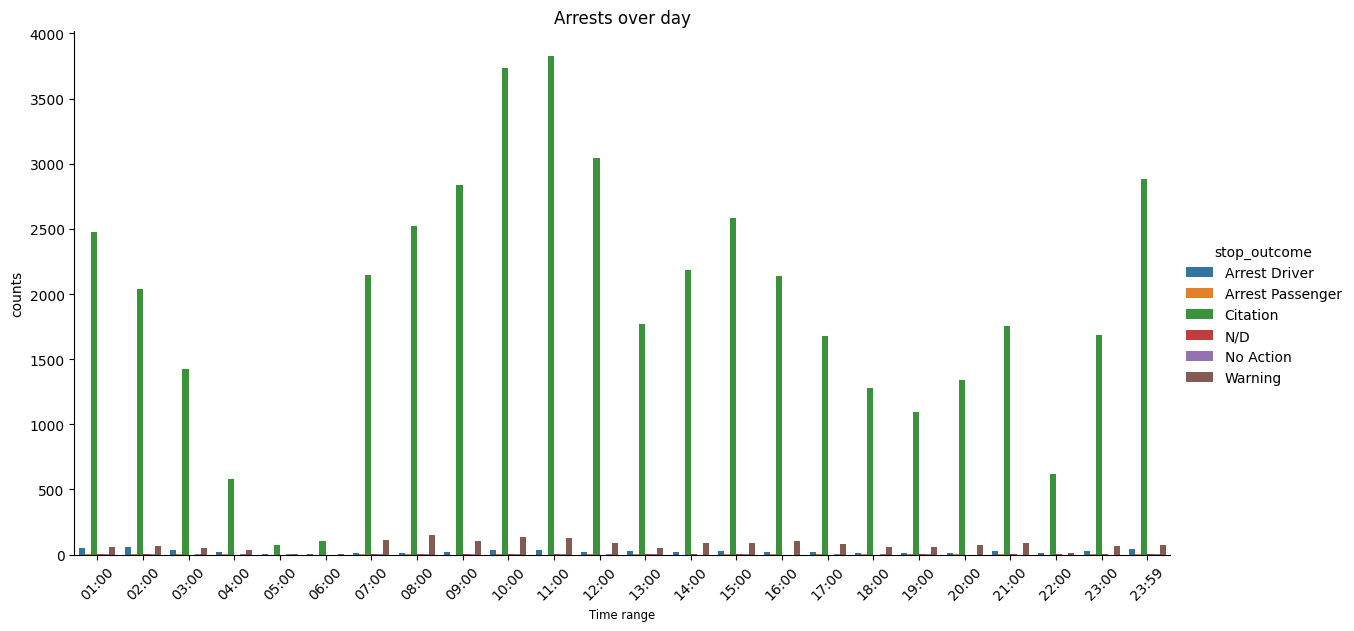

In [34]:
is_arested_in_day = filtered_speed_df.groupby(['stop_outcome', 'time_range']).size().reset_index(name='counts')
total_arrests_per_outcome = is_arested_in_day.groupby('stop_outcome')['counts'].transform('sum')
is_arested_in_day['percentage'] = (is_arested_in_day['counts'] / total_arrests_per_outcome) * 100

sns.catplot(x="time_range", y="counts", hue="stop_outcome", kind="bar", data=is_arested_in_day, height=6, aspect=2)
plt.xticks( rotation=45)
plt.xlabel('Time range', fontsize='small')
plt.title('Arrests over day')
plt.show()

However, it is not uncommon to receive a warning.

/tmp/ipykernel_17/1619928593.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filter_stop_arest=filtered_speed_df[(police_df['stop_outcome'] == 'Warning')|(police_df['stop_outcome'] == 'Arrest Driver')|(police_df['stop_outcome'] == 'Arrest Passenger')].copy(deep=True)


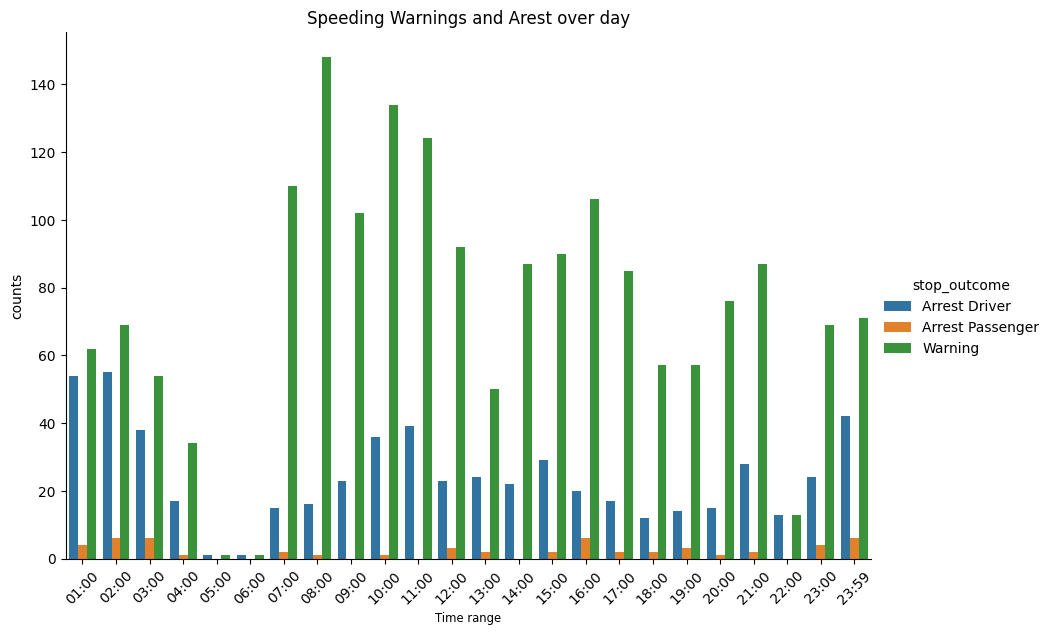

In [35]:
filter_stop_arest=filtered_speed_df[(police_df['stop_outcome'] == 'Warning')|(police_df['stop_outcome'] == 'Arrest Driver')|(police_df['stop_outcome'] == 'Arrest Passenger')].copy(deep=True)
is_arested_in_day = filter_stop_arest.groupby(['stop_outcome', 'time_range']).size().reset_index(name='counts')
total_arrests_per_outcome = is_arested_in_day.groupby('stop_outcome')['counts'].transform('sum')
is_arested_in_day['percentage'] = (is_arested_in_day['counts'] / total_arrests_per_outcome) * 100

sns.catplot(x="time_range", y="counts", hue="stop_outcome", kind="bar", data=is_arested_in_day, height=6, aspect=1.5)
plt.xticks( rotation=45)
plt.xlabel('Time range', fontsize='small')
plt.title('Speeding Warnings and Arest over day')
plt.show()

From 07:00 to 09:00, there is a sharp increase and peak percentage of warnings issued for speeding. One could hypothesize that the police are more lenient during this time due to "morning rush."

Comparing the data, we can say that the average duration of a stop does not depend on the number of specific types of violations, as the peak numbers of violations from section 3.1.3 do not align with the peaks in average stop duration.

It can be hypothesized that the duration of a stop is influenced by the police's workload. Thus, closer to the early morning hours, when the number of violations decreases, the police may not see the need for prolonged inspections. On the other hand, we observe peak values during the night (which might depend on the number of arrests and overall number of violators) and during the day, when "morning rush" has ended and the police have more time to review each incident individually.

## 3.3) Times When the Police are "Less Vigilant"

Let's consider the scenario: A speeding violator who is also under the influence of "substances". At what time of day is it easiest for this person to slip past the police without being noticed?

As we can see in section 3.1.3, violations are least frequent in the early morning hours. However, this does not prove that it’s easier to slip past law enforcement during this time. It’s quite possible that, being the only driver on the road at that time, a violator would still be stopped.

Let's plot a time graph for section 3.1.3 under the condition that the stop was related to drugs (`drugs_related_stop`).

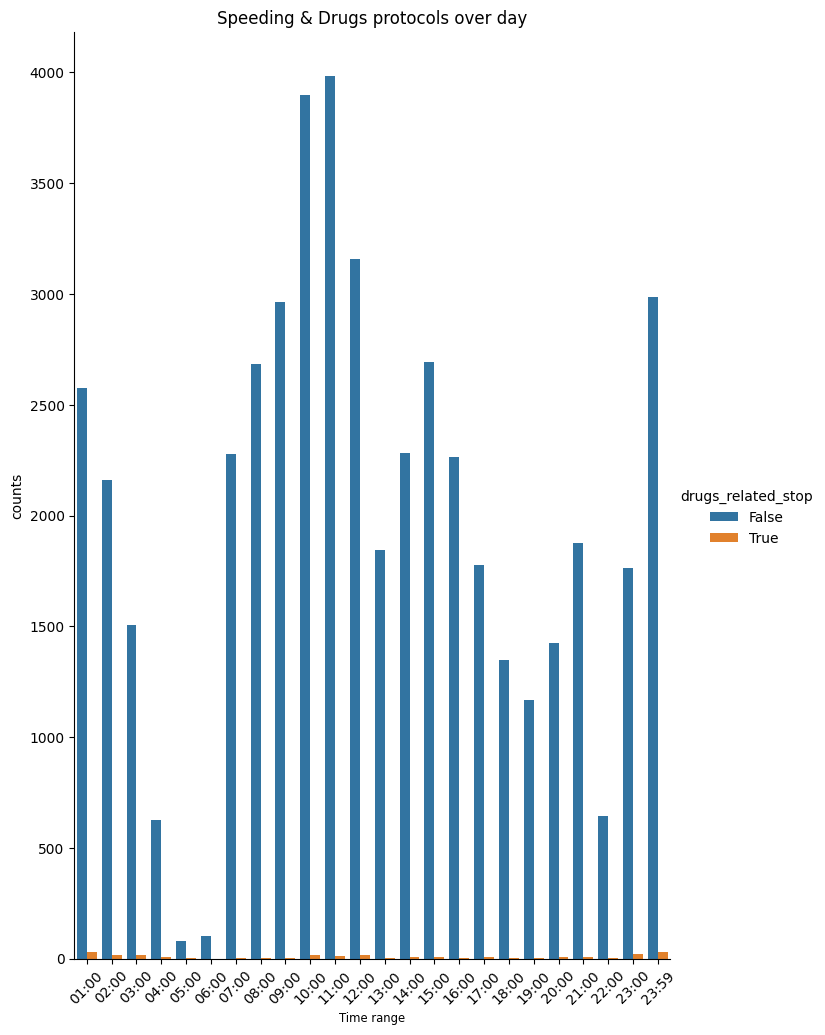

In [36]:
is_arested_in_day = filtered_speed_df.groupby(['drugs_related_stop', 'time_range']).size().reset_index(name='counts')
total_arrests_per_outcome = is_arested_in_day.groupby('drugs_related_stop')['counts'].transform('sum')
is_arested_in_day['percentage'] = (is_arested_in_day['counts'] / total_arrests_per_outcome) * 100

sns.catplot(x="time_range", y="counts", hue="drugs_related_stop", kind="bar", data=is_arested_in_day, height=10, aspect=0.7)
plt.xticks( rotation=45)
plt.xlabel('Time range', fontsize='small')
plt.title('Speeding & Drugs protocols over day')
plt.show()

As we can see, the peak numbers for stops on suspicion of drug use occur at night. During the day, despite the higher overall number of speeding violations, drug-related suspicions are lower. We can conclude that a person stopped for speeding during the day is less likely to be suspected by the police of drug use.

# CONCLUSIONS:
*   We confirmed that speeding violations occur more frequently than other types. Most often, these are committed by young people at night.
*   We found that stops typically last less than 15 minutes, regardless of the number and types of violations. Additionally, we identified the time when arrests most frequently occur and which type of penalty is most common.
*   We established that police tend to conduct more searches and "substance" checks on drivers at night.